# Project 1: Forecast SPY future values.
## Josh Greenert 2/4/2023
### Collect Data

In [84]:
# Pulled data into Google Sheet for SPY close data.
# https://docs.google.com/spreadsheets/d/1x-WmNLFdGM-m1zSTUSt2YZ7RY_dVa4CtOr8Y05S5WvU/edit#gid=0
import pandas as pd

df_spy = pd.read_excel("SPY Forecast.xlsx")
df_spy.head(5)

,Date,Close
0,1993-01-29 16:00:00,43.94
1,1993-02-01 16:00:00,44.25
2,1993-02-02 16:00:00,44.34
3,1993-02-03 16:00:00,44.81
4,1993-02-04 16:00:00,45.00


### Plot the Data

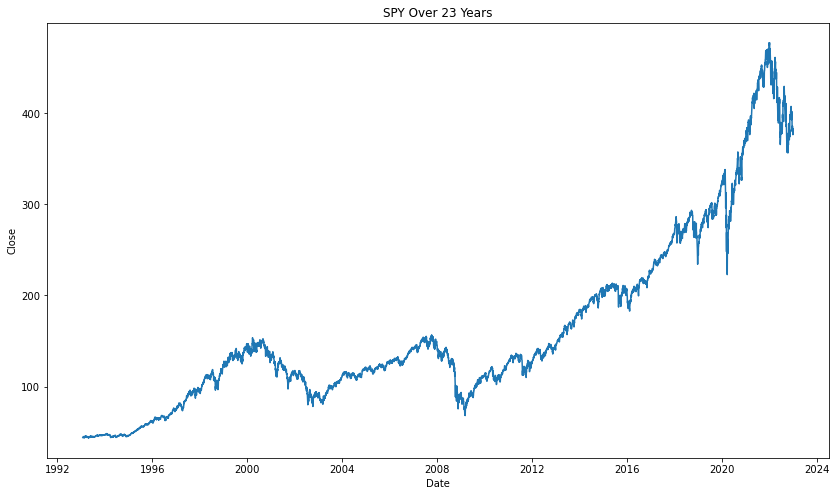

In [85]:
# Data is set in datetime format.  Line graphs view that data fairly well.
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 1, figsize=(14, 8))
plt.plot(df_spy.Date, df_spy.Close)
plt.title('SPY Over 23 Years')
plt.xlabel('Date')
plt.ylabel('Close')
plt.show()

### Prepare Data

In [86]:
# remove all days from the data to create a second model for monthly
df_monthlySpy = df_spy

# Set the values for the monthly dataframe.
df_monthlySpy.set_index('Date', inplace=True)
df_monthlySpy.index = pd.to_datetime(df_monthlySpy.index)
df_monthlySpy = df_monthlySpy.resample('1M').mean()

In [87]:
# Show the head of the data to confirm success.
df_monthlySpy.head(5)

,Close
Date,
1993-01-31,43.940000
1993-02-28,44.291579
1993-03-31,45.120000
1993-04-30,44.357619
1993-05-31,44.663000


### Split the Data Into Test and Train Set

In [89]:
# Set the dates to the beginning of January 2021
testDailyData = df_spy[-503:]
testMonthlyData = df_monthlySpy[-24:]

trainDailyData = df_spy[:-503]
trainMonthlyData = df_monthlySpy[:-24]

In [90]:
# Create a new DatetimeIndex that covers the desired range of dates
start_date = trainDailyData.index.min()
end_date = trainDailyData.index.max()
new_index = pd.date_range(start_date, end_date, freq='D')

# Reindex the DataFrame with the new index and fill in missing values with forward fill
trainDailyData = trainDailyData.reindex(new_index).ffill()

# Create a new DatetimeIndex that covers the desired range of dates
start_date = testDailyData.index.min()
end_date = testDailyData.index.max()
new_index = pd.date_range(start_date, end_date, freq='D')

# Reindex the DataFrame with the new index and fill in missing values with forward fill
testDailyData = testDailyData.reindex(new_index).ffill()

### Train the Set To Build a Predictive Model

In [91]:
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM, Dense
from keras.models import Sequential
import warnings
warnings.filterwarnings("ignore")

# Convert the data to numpy arrays
trainDailyData.index = pd.to_datetime(trainDailyData.index)
train_data = trainDailyData.values
train_data = train_data.reshape((train_data.shape[0], 1))

# Scale the data to be in the range of 0 to 1
scaler = MinMaxScaler(feature_range=(0, 1))
train_data = scaler.fit_transform(train_data)

# Define the number of timesteps (sequence length) for the LSTM network
timesteps = 30

# Create the input and target arrays for the network
x_train = []
y_train = []
for i in range(timesteps, train_data.shape[0]):
    x_train.append(train_data[i-timesteps:i, 0])
    y_train.append(train_data[i, 0])
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data to be in the format [samples, timesteps, features]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# Define the LSTM network
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50))
model.add(Dense(1))

# Compile the network
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the network
model.fit(x_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
318/318 [==============================] - 12s 22ms/step - loss: 0.0025
Epoch 2/100
318/318 [==============================] - 7s 22ms/step - loss: 1.2027e-04
Epoch 3/100
318/318 [==============================] - 7s 21ms/step - loss: 1.0852e-04
Epoch 4/100
318/318 [==============================] - 7s 22ms/step - loss: 1.1098e-04
Epoch 5/100
318/318 [==============================] - 7s 21ms/step - loss: 9.7853e-05
Epoch 6/100
318/318 [==============================] - 7s 22ms/step - loss: 1.0184e-04
Epoch 7/100
318/318 [==============================] - 7s 22ms/step - loss: 8.0878e-05
Epoch 8/100
318/318 [==============================] - 7s 22ms/step - loss: 7.1462e-05
Epoch 9/100
318/318 [==============================] - 7s 22ms/step - loss: 6.9637e-05
Epoch 10/100
318/318 [==============================] - 7s 21ms/step - loss: 6.5162e-05
Epoch 11/100
318/318 [==============================] - 7s 22ms/step - loss: 5.8070e-05
Epoch 12/100
318/318 [======================

318/318 [==============================] - 7s 21ms/step - loss: 2.4722e-05
Epoch 95/100
318/318 [==============================] - 7s 22ms/step - loss: 2.5811e-05
Epoch 96/100
318/318 [==============================] - 7s 21ms/step - loss: 2.5242e-05
Epoch 97/100
318/318 [==============================] - 7s 22ms/step - loss: 2.5654e-05
Epoch 98/100
318/318 [==============================] - 9s 27ms/step - loss: 2.4954e-05
Epoch 99/100
318/318 [==============================] - 8s 27ms/step - loss: 2.5468e-05
Epoch 100/100
318/318 [==============================] - 7s 23ms/step - loss: 2.5600e-05


### Make Some Predictions

In [92]:
# Load the test data and scale it using the scaler from the training data
test_data = testDailyData.values
test_data = test_data.reshape((test_data.shape[0], 1))
test_data = scaler.transform(test_data)

# Create the input data for the network
x_test = []
for i in range(timesteps, test_data.shape[0]):
    x_test.append(test_data[i-timesteps:i, 0])
x_test = np.array(x_test)

# Reshape the data to be in the format [samples, timesteps, features]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Use the model to make predictions
predictions = model.predict(x_test)

# Invert the predictions back to the original scale
predictions = scaler.inverse_transform(predictions)

22/22 [==============================] - 2s 8ms/step


### Check the plots to compare

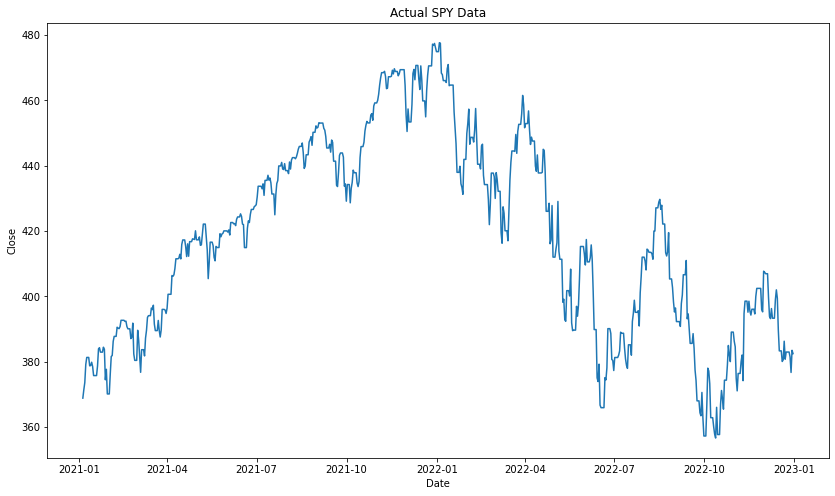

In [93]:
# Plot the new forecast of data.
fig, axes = plt.subplots(1, 1, figsize=(14, 8))
plt.plot(testDailyData)
plt.title('Actual SPY Data')
plt.xlabel('Date')
plt.ylabel('Close')
plt.show()

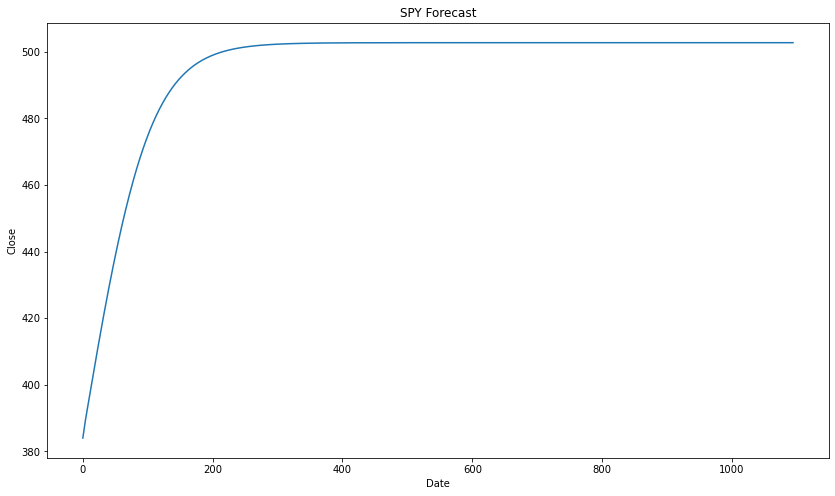

In [97]:
# Plot the new forecast of data.
fig, axes = plt.subplots(1, 1, figsize=(14, 8))
plt.plot(predictions)
plt.title('SPY Forecast')
plt.xlabel('Date')
plt.ylabel('Close')
plt.show()

### Create a new Prediction with a wider range

In [98]:
# Create a date range for the desired time range
start_date = '2021-01-01'
end_date = '2023-12-31'
date_range = pd.date_range(start_date, end_date)

# Create an empty array to store the predictions
predictions = np.empty((len(date_range), 1))

# Set the initial input data for the network
input_data = test_data[-timesteps:, :]

# Loop over the desired time range and make predictions for each time step
for i in range(len(date_range)):
    prediction = model.predict(input_data.reshape(1, input_data.shape[0], input_data.shape[1]))
    predictions[i, :] = prediction
    input_data = np.append(input_data, prediction, axis=0)
    input_data = input_data[-timesteps:, :]

# Invert the predictions back to the original scale
predictions = scaler.inverse_transform(predictions)

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 25ms/step


### Plot the results of the new prediction

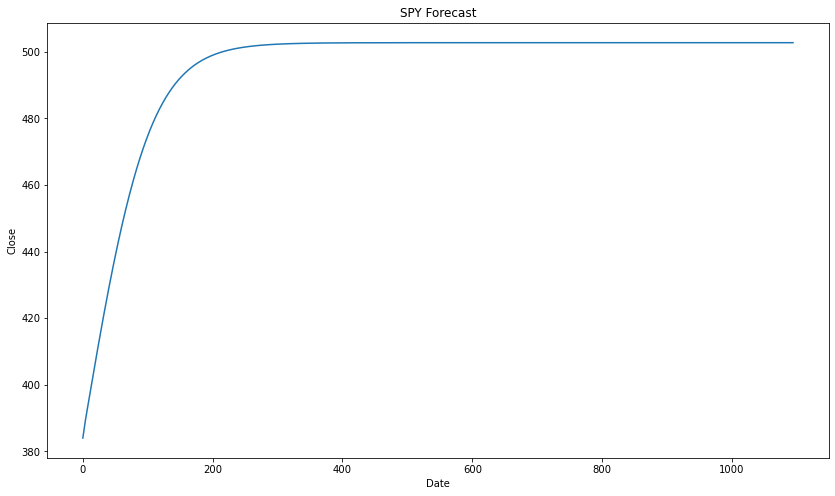

In [99]:
# Plot the new forecast of data.
fig, axes = plt.subplots(1, 1, figsize=(14, 8))
plt.plot(predictions)
plt.title('SPY Forecast')
plt.xlabel('Date')
plt.ylabel('Close')
plt.show()

In [100]:
predictions

array([[384.00264817],
       [385.37206103],
       [386.7606987 ],
       ...,
       [502.74734026],
       [502.74734026],
       [502.74734026]])